In [1]:
%matplotlib inline
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import tqdm
import argparse
import os
import sys
import numpy as np
sys.path.append("..")
from utils import data as dutils
from utils import stimuli as sutils
from utils.data import get_sequences
import matplotlib
import matplotlib.pyplot as plt
import torch.distributions as D
import scienceplots as scp
from matplotlib.ticker import FormatStrFormatter
import math

matplotlib.rcParams['figure.figsize'] = (20, 6)

EPS = 1e-5
PI = torch.acos(torch.zeros(1)).item() * 2

seed = 1973

# set a random seed 
torch.manual_seed(seed)
np.random.seed(seed)

In [2]:
# argument parser 
def parse_args():
    parser = argparse.ArgumentParser()

    """ data paths """
    parser.add_argument("--train_path", type=str, default="./datasets/train",
                        help="Path to training (familiar) images")
    parser.add_argument("--test_path", type=str, default="./datasets/test",
                        help="Path to test (novel) images")
    parser.add_argument("--num_train", type=int, default=40,
                        help="Number of training images to use")
    parser.add_argument("--num_test", type=int, default=40,
                        help="Number of test images to use")

    """ sequence setup """
    parser.add_argument("--image_dim", type=int, default=8)
    parser.add_argument("--blank_ts", type=int, default=5,
                        help="Number of blank time steps")
    parser.add_argument("--img_ts", type=int, default=3,
                        help="Number of image time steps")
    parser.add_argument("--num_pres", type=int, default=6,
                        help="Length of sequence, i.e. number of image presentations")

    """ model parameters """
    parser.add_argument("--h_dim", type=int, default=64)
    parser.add_argument("--device", type=str, default="cpu")
    parser.add_argument("--l2_penalty", type=float, default=0.0)

    """ training parameters """
    parser.add_argument("--lr", type=float, default=0.0001)
    parser.add_argument("--num_epochs", type=int, default=10)
    parser.add_argument("--batch_size", type=int, default=100)
    parser.add_argument('--pos-weight', type=float, default=1.0,
                        metavar='W', help='weight on positive examples (default: 1.0)')

    return parser.parse_known_args()[0]

In [3]:
# functions to retrieve training data
def fetch_sequences(args):
    # load the images
    train_images = np.concatenate([np.load(open(f"./datasets/cifar_features/image_set_cnn_A_seed_{s+1}.npy", 'rb')) for s in range(10)], axis=0) #dutils.load_images_to_numpy_array(args.train_path, grayscale=True, num_images=args.num_train)
    test_images = np.concatenate([np.load(open(f"./datasets/cifar_features/image_set_cnn_C_seed_{s+1}.npy", 'rb')) for s in range(10)], axis=0) #dutils.load_images_to_numpy_array(args.test_path, grayscale=True, num_images=args.num_test)

    """
    # processing params
    process_params = {
        "method": 'downsample',
        "num_pcs": 3,
        "vectorize": True,
        "new_size": (args.image_dim, args.image_dim),
        "downsample_mode": 'avg_pooling'
    }

    # process images
    train_inds = np.random.choice(len(train_images), size=(args.num_train,), replace=False)
    test_inds = np.random.choice(len(test_images), size=(args.num_test,), replace=False)
    train_images = list(sutils.extract_features(train_images[train_inds], **process_params))
    test_images = list(sutils.extract_features(test_images[test_inds], **process_params))
    """

    train_images, test_images = list(train_images), list(test_images)
    train_seqs, train_ts, train_oms = get_sequences(train_images,
                                                    blank_ts=args.blank_ts,
                                                    pres_ts=args.img_ts,
                                                    num_presentations=args.num_pres,
                                                    omission_prob=0.0)
    test_seqs, test_ts, test_oms = get_sequences(test_images, 
                                                 blank_ts=args.blank_ts,
                                                 pres_ts=args.img_ts,
                                                 num_presentations=args.num_pres,
                                                 omission_prob=0.0)

    return train_seqs, train_ts, train_oms, test_seqs, test_ts, test_oms

def get_reward_sequence(batch_size, seq_len, seq_ts,
                        reward_window=6):
    # for each sequence, creates a reward sequence with the reward an agent gets if it licks at time t
    
    reward_seq = torch.zeros((batch_size, seq_len))
    for s in range(len(reward_seq)):
        
        change_time = seq_ts[s]['after'][0][0]
        reward_seq[s, change_time:change_time+reward_window] = 1.0
    
    return reward_seq    

In [4]:
# functions for plotting
def normalize(tensor, reference=None, dim=-1):
    
    if reference is None:
        reference = tensor
    
    minm = reference.min(dim, keepdim=True)[0]
    maxm = reference.max(dim, keepdim=True)[0]
    
    return (tensor - minm) / ((maxm - minm) + EPS)

def plot_change_responses(args, ax, responses, label, clr, sem=True):
    response_mean = responses.mean([0, -1]).detach()
    response_std = responses.mean(-1).std(0).detach() / np.sqrt(responses.shape[0])
    
    ax.axvspan(args.blank_ts, args.blank_ts + args.img_ts, color="r", alpha=0.05)
    ax.axvspan(2 * args.blank_ts + args.img_ts, 2 * (args.blank_ts + args.img_ts), color="b", alpha=0.05)
    
    ax.plot(response_mean.numpy(), label=label, color=clr, linewidth=3.0)
    if sem:
        ax.fill_between(np.arange(responses.shape[1]),
                        response_mean - response_std,
                        response_mean + response_std,
                        color=clr, alpha=0.25)
        #ax.errorbar(np.arange(responses.shape[1]), response_mean, response_std, ecolor=clr)

        
def raincloud_plot(ax, familiar_responses, novel_responses):

    # Create a list of colors for the boxplots based on the number of features you have
    boxplots_colors = ['darkorange', 'darkblue']
    median_colors = ['orangered', 'navy']

    # Boxplot data
    data = [familiar_responses, novel_responses]
    bp = ax.boxplot(data, patch_artist = True, vert = True, showmeans=True, showfliers=False,
                   meanprops={'markersize': 10, 'markerfacecolor': 'darkgreen'})

    # Change to the desired color and add transparency
    for patch, color in zip(bp['boxes'], boxplots_colors):
        patch.set_facecolor(color)
        patch.set_edgecolor(color)
        patch.set_alpha(0.35)
        patch.set_linewidth(2.0)
        patch.set_linestyle('solid')
    
    for patch, color in zip(bp['medians'], median_colors):
        patch.set_color(color)
        patch.set_linewidth(2.5)

    # Create a list of colors for the violin plots based on the number of features you have
    violin_colors = ['orange', 'cornflowerblue']

    # Violinplot data
    vp = ax.violinplot(data, points=500, 
                   showmeans=False, showextrema=False, showmedians=False, vert=True)
    
    for idx, b in enumerate(vp['bodies']):
        # Get the center of the plot
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        # Modify it so we only see the upper half of the violin plot
        b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], idx+1, idx+2)
        # Change to the desired color
        b.set_color(violin_colors[idx])
        b.set_alpha(0.3)
    

    # Create a list of colors for the scatter plots based on the number of features you have
    scatter_colors = ['darkorange', 'darkblue']

    # Scatterplot data
    for idx, features in enumerate(data):
        # Add jitter effect so the features do not overlap on the y-axis
        y = np.full(len(features), idx + .8)
        idxs = np.arange(len(y))
        out = y.astype(float)
        out.flat[idxs] += np.random.uniform(low=-.05, high=.05, size=len(idxs))
        y = out
        plt.scatter(y, features, s=10, c=scatter_colors[idx])

    plt.xticks(np.arange(1,3,1), ['Familiar', 'Novel'])  # Set text labels.
    plt.ylabel('Average response')

In [5]:
# Adapted from: https://github.com/AllenInstitute/STSPNet/blob/master/models.py 

class CoupledGaussianDropout(nn.Module):
    def __init__(self, alpha=1.0):
        super(CoupledGaussianDropout, self).__init__()
        self.alpha = alpha

    def forward(self, x):
        """
        Sample noise   e ~ N(0, alpha)
        Add noise h = h_ * (1 + e)
        """
        epsilon = torch.randn_like(x) * self.alpha + 1

        return x * epsilon


class STPNet(nn.Module):
    def __init__(self,
                 input_dim=64,
                 hidden_dim=16,
                 noise_std=0.5,
                 syn_tau=6,      # syn_tau: recovery time constant
                 syn_u=0.5):     # syn_u: calcium concentration

        super(STPNet, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.syn_tau = syn_tau
        self.syn_u = syn_u

        self.noise = CoupledGaussianDropout(
            alpha=noise_std) if noise_std > 0 else None
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, 1)

    def init_syn_x(self, batch_size=128):
        """Initialize syn_x for the input units."""
        return torch.ones([batch_size, self.input_dim])
    
    def init_hidden(self, batch_size=128):

        return torch.tensor([0.0])

    def forward(self, inputs):
        # add noise
        if self.noise:
            inputs = F.relu(self.noise(inputs))

        k = (1 / self.syn_tau) + self.syn_u * inputs
        syn_x_list = [self.syn_x]
        for i in range(inputs.shape[1]-1):
            # update synaptic plasticity
            # backward Euler
            self.syn_x = (1 / k[:, i]) * ((1 / self.syn_tau) -
                                          ((1 / self.syn_tau) -
                                           self.syn_x * k[:, i]) *
                                          torch.exp(-k[:, i]))
            # # forward Euler
            # self.syn_x = self.syn_x + (1 - self.syn_x) / self.syn_tau - \
            #     self.syn_u * self.syn_x * inputs[:, i]
            # # clamp between [0,1]
            # self.syn_x = torch.clamp(self.syn_x, min=0, max=1)

            syn_x_list.append(self.syn_x)

        input_syn = torch.stack(syn_x_list, dim=1)
        hidden = F.relu(self.linear1(input_syn * inputs))
        if self.noise:
            hidden = F.relu(self.noise(hidden))
        output = self.linear2(hidden)

        return output, hidden, inputs  # , input_syn

class STPRNN(nn.Module):
    def __init__(self,
                 input_dim=64,
                 hidden_dim=16,
                 noise_std=0.5,
                 syn_tau=6,      # syn_tau: recovery time constant
                 syn_u=0.5):     # syn_u: calcium concentration

        super(STPRNN, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.syn_tau = syn_tau
        self.syn_u = syn_u

        self.noise = CoupledGaussianDropout(
            alpha=noise_std) if noise_std > 0 else None

        self.register_parameter(
            'weight_ih', nn.Parameter(torch.Tensor(input_dim * 2, hidden_dim)))
        self.register_parameter(
            'weight_hh', nn.Parameter(torch.Tensor(hidden_dim, hidden_dim)))
        self.register_parameter(
            'bias', nn.Parameter(torch.Tensor(hidden_dim)))
        self.init_weights()

        self.linear = nn.Linear(hidden_dim, 1)

    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_dim)
        for weight in self.parameters():
            nn.init.uniform_(weight, -stdv, stdv)

    def init_syn_x(self, batch_size=128):
        """Initialize syn_x for the input units."""
        return torch.ones([batch_size, self.input_dim])

    def init_hidden(self, batch_size=128):
        """Initialize hidden state of RNN."""
        return torch.zeros([1, batch_size, self.hidden_dim])

    def forward(self, inputs):
        """Assumes input is of shape (batch, sequence, feature)"""
        # add noise
        if self.noise:
            inputs = F.relu(self.noise(inputs))

        k = (1 / self.syn_tau) + self.syn_u * inputs
        syn_x_list = [self.syn_x]
        for i in range(inputs.shape[1]-1):
            # update synaptic plasticity
            # backward Euler
            self.syn_x = (1 / k[:, i]) * ((1 / self.syn_tau) -
                                          ((1 / self.syn_tau) -
                                           self.syn_x * k[:, i]) *
                                          torch.exp(-k[:, i]))
            # # forward Euler
            # self.syn_x = self.syn_x + (1 - self.syn_x) / self.syn_tau - \
            #     self.syn_u * self.syn_x * inputs[:, i]
            # # clamp between [0,1]
            # self.syn_x = torch.clamp(self.syn_x, min=0, max=1)

            syn_x_list.append(self.syn_x)

        # concatenate original inputs and depressed inputs
        input_syn = torch.stack(syn_x_list, dim=1)
        inputs = torch.cat((inputs, input_syn * inputs), dim=2)

        hidden = []
        for i in range(inputs.shape[1]):
            x = inputs[:, i, :]
            # batch the computations into a single matrix multiplication
            self.hidden = x @ self.weight_ih + self.hidden @ self.weight_hh + self.bias
            self.hidden = F.relu(self.hidden)
            if self.noise:
                self.hidden = F.relu(self.noise(self.hidden))

            hidden.append(self.hidden)

        # update hidden layer
        hidden = torch.cat(hidden, dim=0)
        hidden = hidden.transpose(0, 1).contiguous()
        output = self.linear(hidden)

        return output, hidden, inputs


In [6]:
# training functions
def training_epoch(model, optimizer, dataloader, epoch, criterion=None, l2_penalty=0.0, device='cuda'):
    
    model.train()
    
    pbar = tqdm.tqdm(dataloader, unit='batch')
    pbar.set_description(f"Epoch {epoch}")
    
    for itr, (Y, labels) in enumerate(pbar):
        Y = Y.to(device)
        labels = labels.to(device)
        
        model.syn_x = model.init_syn_x(Y.shape[0]).to(device)
        model.hidden = model.init_hidden(Y.shape[0]).to(device)
        
        # mask for blank presentations
        loss_mask = torch.abs(torch.sign(Y.mean(-1).squeeze().abs())).detach()
        
        optimizer.zero_grad()
        output, hidden, _ = model(Y)

        # Convert to binary prediction
        output = torch.sigmoid(output)
        pred = torch.bernoulli(output).byte()

        if criterion is None:
            loss = torch.nn.BCEWithLogitsLoss(reduction='none')(output.squeeze(), labels)
        else:
            loss = criterion(output.squeeze(), labels)
        # Apply mask and take mean
        loss = (loss * loss_mask).mean()

        # L2 loss on hidden unit activations
        L2_loss = hidden.pow(2).mean()
        loss += l2_penalty * L2_loss

        loss.backward()
        optimizer.step()
            
        # update the progress bar
        pbar.set_postfix(loss=loss.item())

def train(model, optimizer, dataloader, criterion=None, l2_penalty=0.0, num_epochs=50, device='cuda'):
    
    for epoch in range(num_epochs):
        
        training_epoch(model, optimizer, dataloader, epoch, criterion, l2_penalty, device)    

In [7]:
# dataset object to hold data
class SequenceDataset(Dataset):
    
    def __init__(self, data_tensor, rewards_tensor):
        self.x = data_tensor
        self.R = rewards_tensor
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.R[idx]

In [8]:
# ---------------------------------------------------------- TRAINING ------------------------------------------------------- #
# parse arguments
args = parse_args()

# train and test sequences
train_seqs, train_ts, train_oms, test_seqs, test_ts, test_oms = fetch_sequences(args)
y_dim = train_seqs.shape[-1]

# create reward tensor for train and test sequences
R_train = get_reward_sequence(*train_seqs.shape[:2], train_ts, reward_window=args.img_ts+2)
R_test = get_reward_sequence(*test_seqs.shape[:2], test_ts, reward_window=args.img_ts+2)

# TODO: should we normalize images to be between 0 and 1?
Y_train = torch.Tensor(train_seqs).float().to(args.device)
Y_test = torch.Tensor(test_seqs).float()

# create data loaders
train_dataset = SequenceDataset(Y_train, R_train)
test_dataset = SequenceDataset(Y_test, R_test)
train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True)

# create model
model = STPNet(y_dim, args.h_dim, noise_std=0.5, syn_tau=3).to(args.device)

# create optimizer
opt = torch.optim.Adam(model.parameters(), lr=args.lr)

# loss criterion
criterion = torch.nn.BCEWithLogitsLoss(reduction='none', pos_weight=torch.tensor([args.pos_weight]).to(args.device))

In [9]:
train(model, opt, train_dataloader, criterion=criterion, l2_penalty=args.l2_penalty, num_epochs=args.num_epochs, device=args.device)

Epoch 0:   0%|          | 0/81 [00:00<?, ?batch/s]/home/asharafeldin3/anaconda3/envs/allen/lib/python3.9/site-packages/torch/autograd/__init__.py:197: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 9: 100%|██████████| 81/81 [00:01<00:00, 80.08batch/s, loss=0.263]


In [10]:
# ---------------------------------------------------------- EVALUATION ------------------------------------------------------------- #
model.syn_x = model.init_syn_x(Y_train.shape[0]).to(args.device)
model.hidden = model.init_hidden(Y_train.shape[0]).to(args.device)
train_out, train_hidden, _ = model(Y_train.to(args.device))
model.syn_x = model.init_syn_x(Y_test.shape[0]).to(args.device)
model.hidden = model.init_hidden(Y_test.shape[0]).to(args.device)
test_out, test_hidden, _ = model(Y_test.to(args.device)) 

train_licks = torch.bernoulli(torch.sigmoid(train_out)).byte().squeeze()
test_licks = torch.bernoulli(torch.sigmoid(test_out)).byte().squeeze()

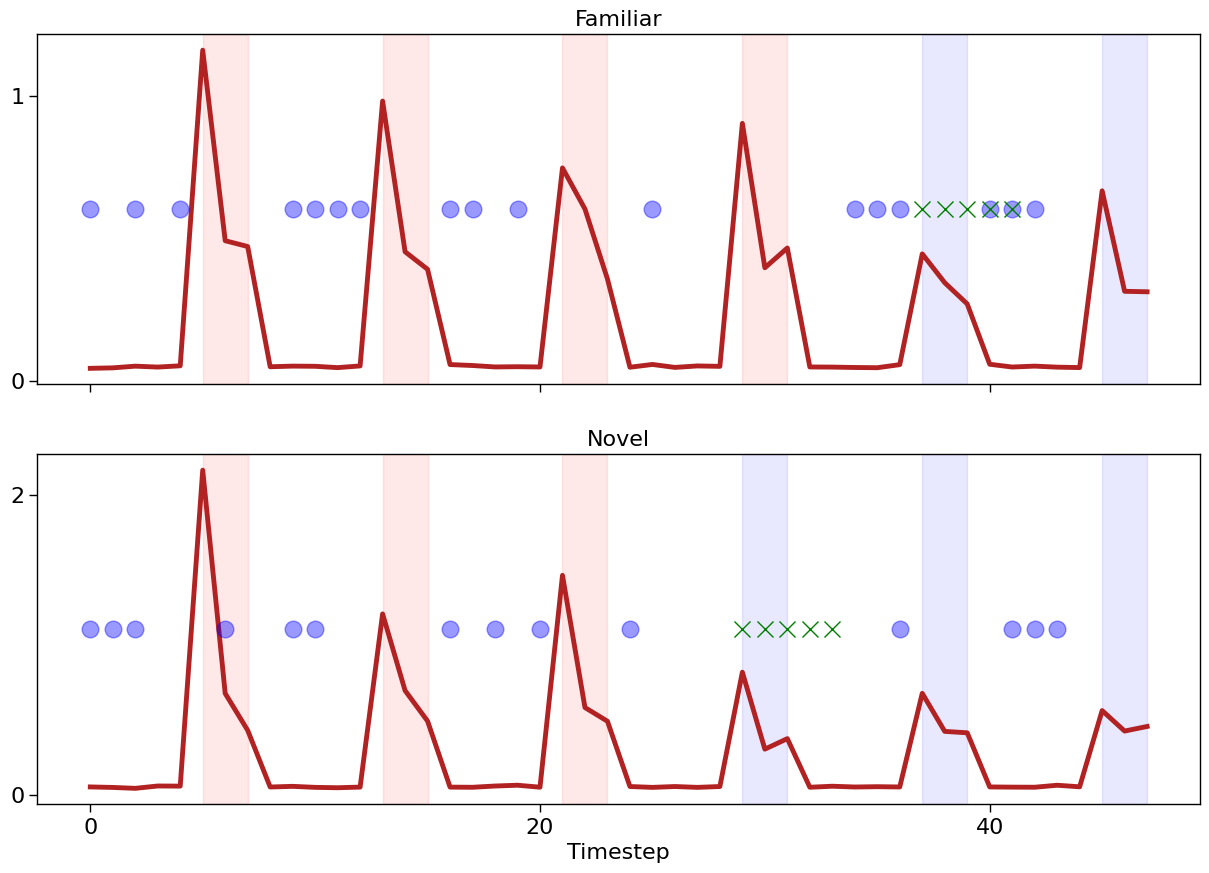

In [11]:
# example sequences (familiar)
train_seq = 13
test_seq = 10

fig1 = plt.figure(figsize=(15, 10))

#train_mask = torch.abs(torch.sign(Y_train.mean(-1).squeeze())).detach()
#test_mask = torch.abs(torch.sign(Y_test.mean(-1).squeeze())).detach()
licks_inds_train = train_licks[train_seq].nonzero()
licks_inds_test = test_licks[test_seq].nonzero()
train_true = R_train[train_seq].nonzero()
test_true = R_test[test_seq].nonzero()

with plt.style.context(['nature', 'notebook']):

    ax1 = plt.subplot(2, 1, 1)
    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    

    for bf_on, bf_off in zip(*train_ts[train_seq]['before']):
        ax1.axvspan(bf_on, bf_off-1, color="r", alpha=0.09)

    for af_on, af_off in zip(*train_ts[train_seq]['after']):
        ax1.axvspan(af_on, af_off-1, color="b", alpha=0.09)
    
    for bf_on, bf_off in zip(*test_ts[test_seq]['before']):
        ax2.axvspan(bf_on, bf_off-1, color="r", alpha=0.09)

    for af_on, af_off in zip(*test_ts[test_seq]['after']):
        ax2.axvspan(af_on, af_off-1, color="b", alpha=0.09)

    ax1.plot(train_hidden[train_seq].mean(-1).cpu().detach().numpy(), c='firebrick', label="exc", linewidth=3.5)
    ax1.set_title("Familiar")
    ax1.locator_params('x', nbins=4)
    ax1.locator_params('y', nbins=2)
    
    ax2.plot(test_hidden[test_seq].mean(-1).cpu().detach().numpy(), c='firebrick', label="exc", linewidth=3.5)
    ax2.set_xlabel("Timestep")
    ax2.set_title("Novel")
    ax2.locator_params('x', nbins=4)
    ax2.locator_params('y', nbins=2)
    
    ax1.tick_params('x', which='both', top=False, labelbottom=False)
    
    # plot licks
    ymin, ymax = ax1.get_ylim()
    vertical_center = (ymin + ymax) / 2
    ax1.plot(licks_inds_train.cpu().numpy(), [vertical_center]*len(licks_inds_train), 'bo', markersize=12, alpha=0.4)
    ax1.plot(train_true.cpu().numpy(), [vertical_center]*len(train_true), 'gx', markersize=12, alpha=1.0)
    
    # plot licks
    ymin, ymax = ax2.get_ylim()
    vertical_center = (ymin + ymax) / 2
    ax2.plot(licks_inds_test.cpu().numpy(), [vertical_center]*len(licks_inds_test), 'bo', markersize=12, alpha=0.4)
    ax2.plot(test_true.cpu().numpy(), [vertical_center]*len(test_true), 'gx', markersize=12, alpha=1.0)

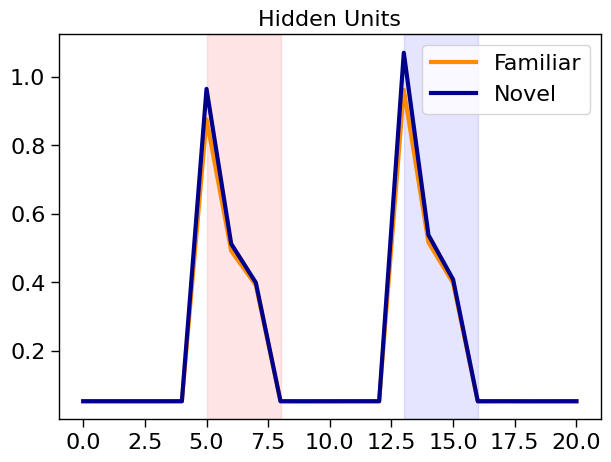

In [12]:
# plot responses around image change
train_change = torch.zeros(train_hidden.shape[0], (3 * args.blank_ts + 2 * args.img_ts), train_hidden.shape[-1])
test_change = torch.zeros(test_hidden.shape[0], (3 * args.blank_ts + 2 * args.img_ts), test_hidden.shape[-1])

for s in range(train_change.shape[0]):
    if train_oms[s] >= 0:
        continue
    start = train_ts[s]['before'][0][-1] - args.blank_ts
    end = train_ts[s]['after'][1][0] + args.blank_ts
    train_change[s] = train_hidden[s, start:end, :]
    
for s in range(test_change.shape[0]):
    if test_oms[s] >= 0:
        continue
    start = test_ts[s]['before'][0][-1] - args.blank_ts
    end = test_ts[s]['after'][1][0] + args.blank_ts
    test_change[s] = test_hidden[s, start:end, :]

with plt.style.context(['nature', 'notebook']):

    fig3 = plt.figure(figsize=(7, 5))
    plt.tight_layout(pad=10, h_pad=5)

    ax3 = plt.subplot(1, 1, 1)

    plot_change_responses(args, ax3, train_change, "Familiar", "darkorange")
    plot_change_responses(args, ax3, test_change, "Novel", "darkblue")
    ax3.set_title("Hidden Units")
    ax3.legend()